In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4


# analysis

In [2]:
datasetName="/stor/public/hcad/lung_lung_HCLFetalLung2/lung_lung_HCLFetalLung2"

In [3]:
# scRNA
raw_data <- read.csv(paste0(datasetName, "_expression.tsv.gz"),header = TRUE, sep='\t',row.names = 1)

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)

In [5]:
# build object
dataobj <- CreateSeuratObject(counts = raw_data, project = "HCAd",meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [6]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [7]:
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))

PC_ 1 
Positive:  TMSB4X, ESAM, PCAT19, CDH5, CD93, TM4SF1, CLDN5, PECAM1, VWF, MT-ATP6 
	   APLNR, CD34, TIE1, MT-ND4, ITM2A, SOX7, RNASE1, ECSCR, GMFG, SDPR 
	   RAMP2, MT-CO3, EPAS1, CALCRL, TMSB10, HPGD, MT-CO1, IL33, RGS5, MT-CO2 
Negative:  COL1A2, COL3A1, COL1A1, MYLK, COL5A2, PLAC9, KIAA0101, SDC2, C2orf40, ISLR 
	   FOXF2, TDO2, OVOS2, G0S2, CCDC80, HMGB2, DAAM2, CRYAB, LPL, OGN 
	   ACTA2, WNT2, FAM162B, TNC, NEXN, NUF2, LINC01314, UBE2C, CXCL12, MROH8 
PC_ 2 
Positive:  CD93, ESAM, CDH5, PECAM1, TM4SF1, PCAT19, VWF, CALCRL, CLDN5, EPAS1 
	   TIE1, SOX7, APLNR, IGFBP4, CD34, COL4A1, EGFL7, ECSCR, ITM2A, IL33 
	   HPGD, HLA-E, CLEC14A, RAMP2, SDPR, EMCN, EDN1, ARHGAP18, PTRF, CAV1 
Negative:  CPM, RPS27, TPPP3, RPL37A, RPS3A, RPL31, RPS6, RPS19, RPL39, RPL34 
	   RPS29, EEF1A1, RPS14, NPC2, RPL27A, RPL41, RPL35A, EPCAM, RPS24, RPS4X 
	   CYR61, RPL13A, RPS20, RPS3, ATP11A, RPS18, RPL11, RPL37, RPLP1, RPL5 
PC_ 3 
Positive:  HLA-DRA, AIF1, RPS29, RPS18, S100A4, RPLP1, RPL21, HM

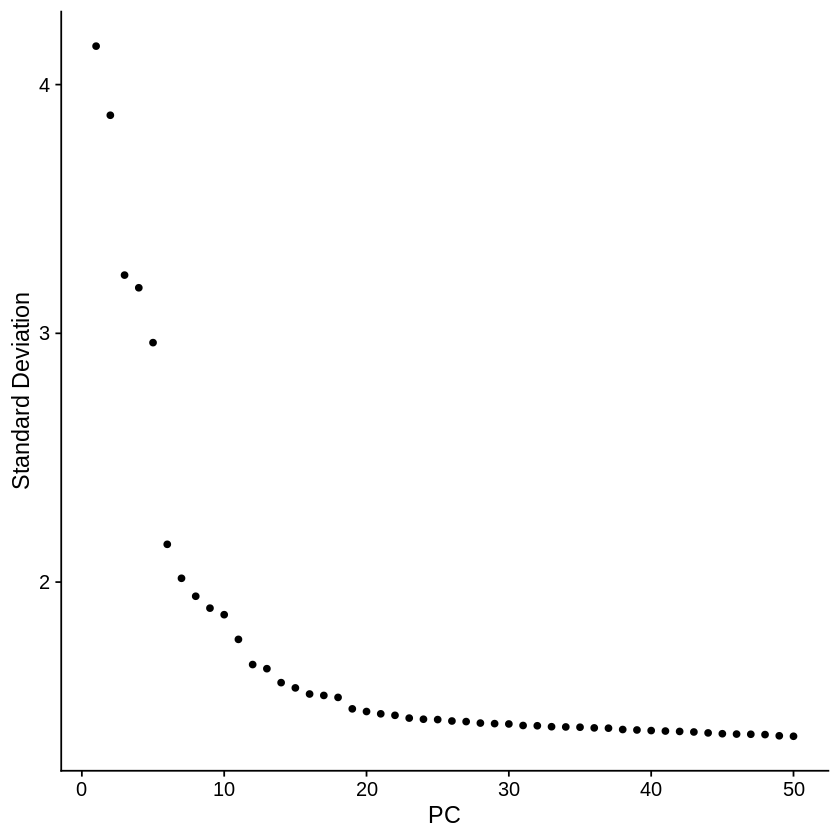

In [8]:
ElbowPlot(dataobj,50) 

In [9]:
pcDim = 30
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”20:09:18 UMAP embedding parameters a = 0.9922 b = 1.112
20:09:18 Read 5121 rows and found 30 numeric columns
20:09:18 Using Annoy for neighbor search, n_neighbors = 30
20:09:18 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
20:09:20 Writing NN index file to temp file /tmp/Rtmp0iQgCc/file7ad9557e9336
20:09:20 Searching Annoy index using 1 thread, search_k = 3000
20:09:21 Annoy recall = 100%
20:09:22 Commencing smooth kNN distance calibration using 1 thread
20:09:22 Initializing from normalized Laplacian + noise
20:09:23 Commencing optimizatio

In [10]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

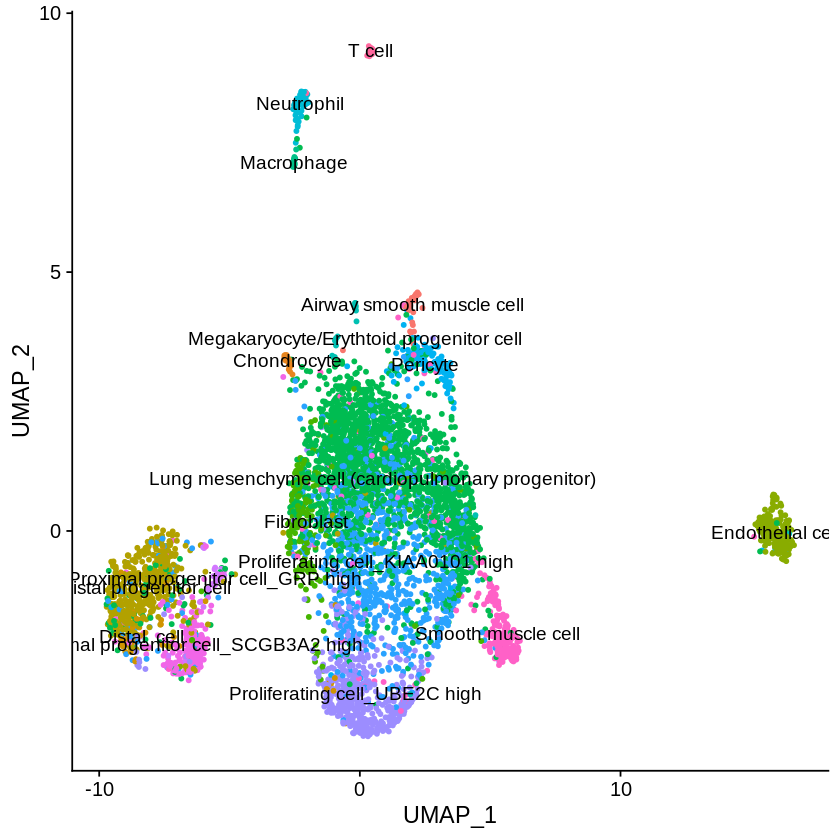

In [11]:
p_umap2

# Clustering

In [12]:
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph
Computing SNN


In [31]:
dataobj <- FindClusters(dataobj, resolution = 1, n.start = 20)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5121
Number of edges: 235973

Running Louvain algorithm...
Maximum modularity in 20 random starts: 0.7178
Number of communities: 14
Elapsed time: 1 seconds


In [32]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

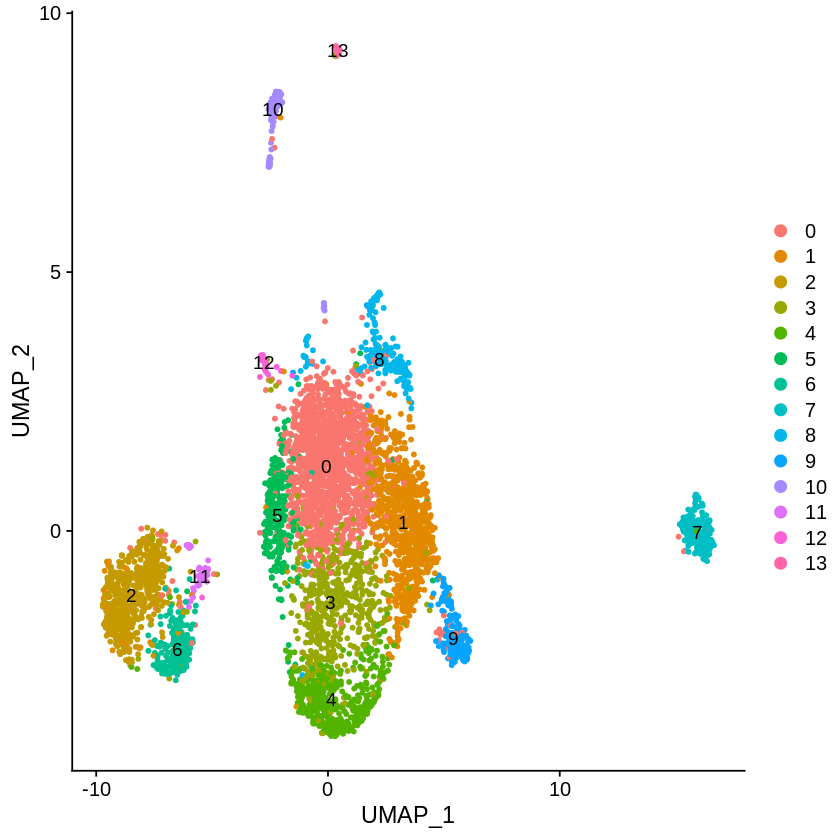

In [33]:
p_umap

# Finding cluster markers 

In [25]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13


# Annotation

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [4]:
dataobj.markers <- read.table(paste0(datasetName,".seurat.markers.txt"), sep = "\t", h = T)

In [68]:
dataobj.markers[dataobj.markers['cluster']==13,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
769,0.000000e+00,3.6041636,0.667,0.003,0.000000e+00,13,CD52
770,0.000000e+00,2.8301821,0.542,0.000,0.000000e+00,13,KLRB1
771,0.000000e+00,2.6768076,0.458,0.001,0.000000e+00,13,LTB
772,0.000000e+00,2.3723478,0.375,0.001,0.000000e+00,13,TRBC1
773,8.047734e-285,2.3275964,0.292,0.000,1.838424e-280,13,TRDC
774,1.211787e-228,1.9469993,0.333,0.001,2.768207e-224,13,IL2RG
775,2.133894e-193,2.9022849,0.458,0.004,4.874667e-189,13,RGS1
776,7.790688e-187,3.2776068,0.792,0.014,1.779705e-182,13,SRGN
777,4.885196e-186,2.9435968,0.333,0.002,1.115974e-181,13,NKG7


In [74]:
dataobj.markers[dataobj.markers['gene']=='LEF1',]

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>


In [4]:
new.cluster.ids <- c(
                     'Lung-Connective Tissue-Fibroblast-DCN LUM',#0
                     'Lung-Connective Tissue-Mesenchymal cell-RPS18',
                     'Lung-Epithelial Tissue-Distal progenitor cell-CPM TPPP3',#to be AT1 and AT2
                     'Lung-Connective Tissue-NK cell-CDK1 TOP2A',
                     'Lung-Connective Tissue-Mesenchymal cell-UBE2C',
                     'Lung-Connective Tissue-Fibroblast-COL1A2',#5
                     'Lung-Epithelial Tissue-Proximal progenitor cell-SCGB3A2',# to be Epithelial cell
                     'Lung-Epithelial Tissue-Endothelial cell-POSTN CLDN5',
                     'Lung-Epithelial Tissue-Myoepithelial cell-ACTA2',
                     'Lung-Musle Tissue-Smooth muscle cell-ACTA2 MYL9',
                     'Lung-Connective Tissue-Macrophage-CD74 HLA-DRA',#10
                     'Lung-Epithelial Tissue-Proximal progenitor cell-SCGB3A2',# to be Epithelial cell
                     'Lung-Cartiage tissue-Chondrocyte-HAPLN1',
                     'Lung-Connective Tissue-Macrophage-NKG'
                     
                   )

In [5]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 1) + NoLegend()

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

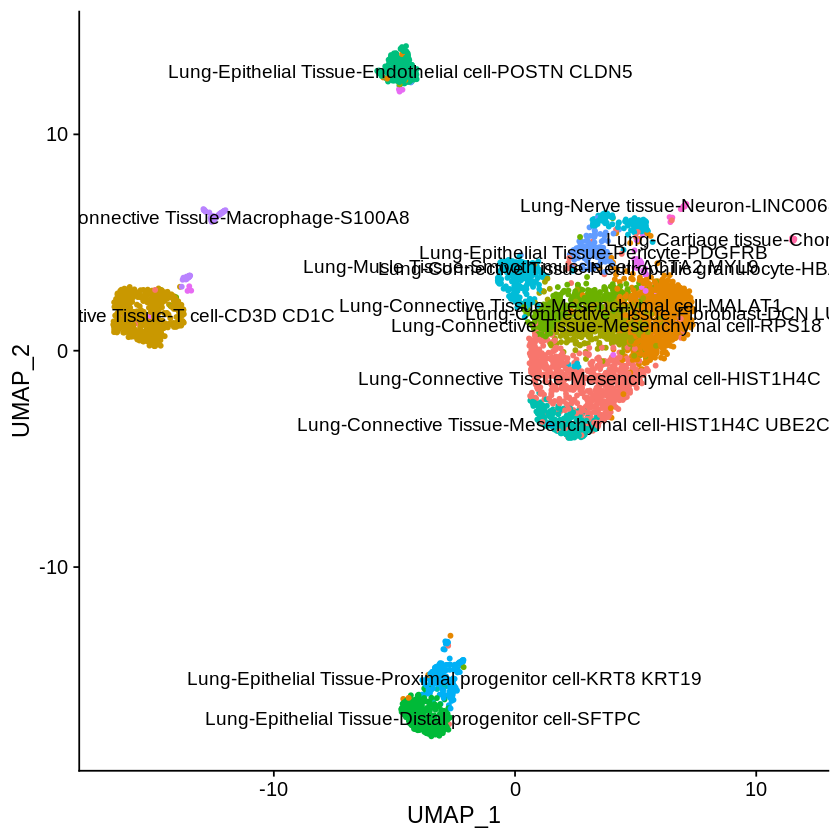

In [96]:
plot

In [97]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = plot, width = 8, height = 5)

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [6]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [7]:
dataobj@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,RNA_snn_res.1,seurat_clusters,RNA_snn_res.2,RNA_snn_res.3,hcad.label
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
FetalLung_2.AAAACGAAAGTTAAAACG,FetalLung,435,344,Lung,Lung,NA,normal,FetalLung2,Female,11W,Lung mesenchyme cell (cardiopulmonary progenitor),0,0,3,2,Lung-Connective Tissue-Fibroblast-DCN LUM
FetalLung_2.AAAACGAACGCCGCTCAA,FetalLung,615,465,Lung,Lung,NA,normal,FetalLung2,Female,11W,Distal progenitor cell,2,2,4,11,Lung-Epithelial Tissue-Distal progenitor cell-CPM TPPP3
FetalLung_2.AAAACGAATAAACATGAT,FetalLung,322,266,Lung,Lung,NA,normal,FetalLung2,Female,11W,Lung mesenchyme cell (cardiopulmonary progenitor),0,0,3,10,Lung-Connective Tissue-Fibroblast-DCN LUM
FetalLung_2.AAAACGACACCCCACAAG,FetalLung,615,449,Lung,Lung,NA,normal,FetalLung2,Female,11W,Lung mesenchyme cell (cardiopulmonary progenitor),9,9,11,17,Lung-Musle Tissue-Smooth muscle cell-ACTA2 MYL9
FetalLung_2.AAAACGACACCCTGCGGA,FetalLung,1204,820,Lung,Lung,NA,normal,FetalLung2,Female,11W,Proliferating cell_UBE2C high,2,2,14,11,Lung-Epithelial Tissue-Distal progenitor cell-CPM TPPP3
FetalLung_2.AAAACGACGAGCTAGAGA,FetalLung,325,288,Lung,Lung,NA,normal,FetalLung2,Female,11W,Lung mesenchyme cell (cardiopulmonary progenitor),0,0,1,1,Lung-Connective Tissue-Fibroblast-DCN LUM
FetalLung_2.AAAACGACTTATACGAGC,FetalLung,355,289,Lung,Lung,NA,normal,FetalLung2,Female,11W,Lung mesenchyme cell (cardiopulmonary progenitor),0,0,1,1,Lung-Connective Tissue-Fibroblast-DCN LUM
FetalLung_2.AAAACGAGCGAGCAAAGT,FetalLung,1237,821,Lung,Lung,NA,normal,FetalLung2,Female,11W,Endothelial cell,7,7,12,14,Lung-Epithelial Tissue-Endothelial cell-POSTN CLDN5
FetalLung_2.AAAACGAGGACTCGCACC,FetalLung,577,436,Lung,Lung,NA,normal,FetalLung2,Female,11W,Proliferating cell_UBE2C high,3,3,7,4,Lung-Connective Tissue-NK cell-CDK1 TOP2A


In [8]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [101]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [102]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)

# update annoation

In [88]:
dataobj <- readRDS("/stor/public/hcad/db_v1/lung_lung_HCLFetalLung2/lung_lung_HCLFetalLung2.seuratobj.dbupload_v1.rds")

In [89]:
dataobj

An object of class Seurat 
43878 features across 5121 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [90]:
table(dataobj$original_name[dataobj$hcad_name == "Lung-Connective tissue-Macrophage-NKG7"])


T cell 
    24 

In [91]:
dataobj$cell_type[dataobj$hcad_name == "Lung-Connective tissue-Macrophage-NKG7"] <- "T cell"
dataobj$tissue_type[dataobj$hcad_name == "Lung-Connective tissue-Macrophage-NKG7"] <- "Connective tissue"
dataobj$marker_gene[dataobj$hcad_name == "Lung-Connective tissue-Macrophage-NKG7"] <- "NKG7"
dataobj$hcad_name[dataobj$hcad_name == "Lung-Connective tissue-Macrophage-NKG7"] <- "Lung-Connective tissue-T cell-NKG7"

In [92]:
saveRDS(dataobj, "/stor/public/hcad/db_v1.1/lung_lung_HCLFetalLung2/lung_lung_HCLFetalLung2.seuratobj.dbupload_v1.rds")